# Steam Game Reviews — Playtime vs Recommendation
DSA210 — Data Science Term Project  
Kerem Ersoy

I want to explore whether players who play a game longer are more likely to recommend it on Steam.  

This dataset contains user reviews for Steam games, including:
 / hours played
 / whether the review recommends the game
 / game name and review text

For the 28 November submission i will,
 / Load and clean this dataset
 / Perform exploratory data analysis
 / Run hypothesis tests about the relationship between playtime and recommendation


In [1]:
import os
os.makedirs("data", exist_ok=True)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 100)


In [6]:
df = pd.read_csv(
    "data/steam_game_reviews.csv",
    engine="python",
    on_bad_lines="skip"
)

df.shape, df.columns


((79179, 8),
 Index(['review', 'hours_played', 'helpful', 'funny', 'recommendation', 'date',
        'game_name', 'username'],
       dtype='object'))

In [7]:
df.head()


,review,hours_played,helpful,funny,recommendation,date,game_name,username
0,The game itself is also super fun. The PvP and...,39.9,"1,152",13,Recommended,14 September,"Warhammer 40,000: Space Marine 2",Sentinowl\n224 products in account
1,Never cared much about Warhammer until this ga...,91.5,712,116,Recommended,13 September,"Warhammer 40,000: Space Marine 2",userpig\n248 products in account
2,A salute to all the fallen battle brothers who...,43.3,492,33,Recommended,14 September,"Warhammer 40,000: Space Marine 2",Imparat0r\n112 products in account
3,this game feels like it was made in the mid 20...,16.8,661,15,Recommended,14 September,"Warhammer 40,000: Space Marine 2",Fattest_falcon
4,Reminds me of something I've lost. A genuine g...,24.0,557,4,Recommended,12 September,"Warhammer 40,000: Space Marine 2",Jek\n410 products in account


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79179 entries, 0 to 79178
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review          79155 non-null  object
 1   hours_played    79179 non-null  object
 2   helpful         79179 non-null  object
 3   funny           79179 non-null  object
 4   recommendation  79179 non-null  object
 5   date            79179 non-null  object
 6   game_name       79179 non-null  object
 7   username        79170 non-null  object
dtypes: object(8)
memory usage: 4.8+ MB


In [9]:
# Cleaning part
data = df[["game_name", "hours_played", "recommendation"]].copy()

data = data.dropna(subset=["hours_played", "recommendation"])

data["hours_played"] = pd.to_numeric(data["hours_played"], errors="coerce")
data = data.dropna(subset=["hours_played"])


data["rec_binary"] = (data["recommendation"].str.strip() == "Recommended").astype(int)

data.head()


,game_name,hours_played,recommendation,rec_binary
0,"Warhammer 40,000: Space Marine 2",39.9,Recommended,1
1,"Warhammer 40,000: Space Marine 2",91.5,Recommended,1
2,"Warhammer 40,000: Space Marine 2",43.3,Recommended,1
3,"Warhammer 40,000: Space Marine 2",16.8,Recommended,1
4,"Warhammer 40,000: Space Marine 2",24.0,Recommended,1


In [10]:
data[["hours_played", "rec_binary"]].describe()

,hours_played,rec_binary
count,66050.000000,66050.000000
mean,189.464032,0.620560
std,235.163206,0.485251
min,0.000000,0.000000
25%,23.200000,0.000000
50%,84.250000,1.000000
75%,268.900000,1.000000
max,999.900000,1.000000


from matplotlib import pyplot as plt
_df_0['hours_played'].plot(kind='hist', bins=20, title='hours_played')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['rec_binary'].plot(kind='hist', bins=20, title='rec_binary')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='hours_played', y='rec_binary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['hours_played'].plot(kind='line', figsize=(8, 4), title='hours_played')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['rec_binary'].plot(kind='line', figsize=(8, 4), title='rec_binary')
plt.gca().spines[['top', 'right']].set_visible(False)

In this section, I:

/ examine the distribution of playtime

/ look at the scales of recommended vs not recommended reviews

/ visualize the relationship between playtime and recommendation


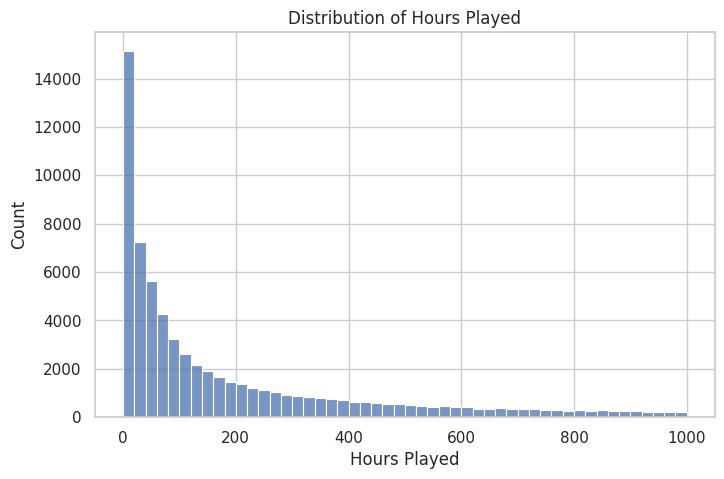

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(data["hours_played"], bins=50)
plt.title("Distribution of Hours Played")
plt.xlabel("Hours Played")
plt.ylabel("Count")
plt.show()


In [12]:
data["rec_binary"].value_counts(normalize=True)


,proportion
rec_binary,
1,0.62056
0,0.37944


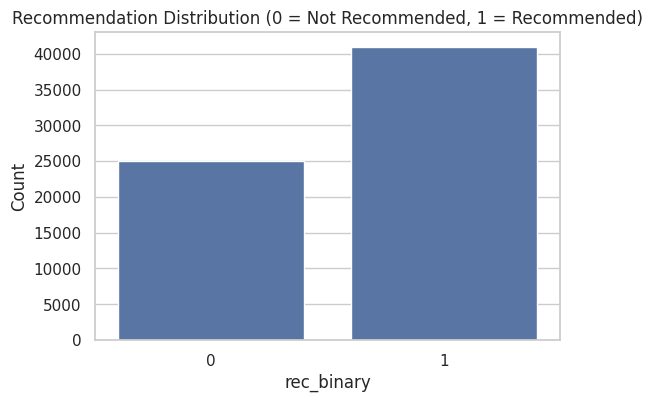

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x="rec_binary", data=data)
plt.title("Recommendation Distribution (0 = Not Recommended, 1 = Recommended)")
plt.xlabel("rec_binary")
plt.ylabel("Count")
plt.show()


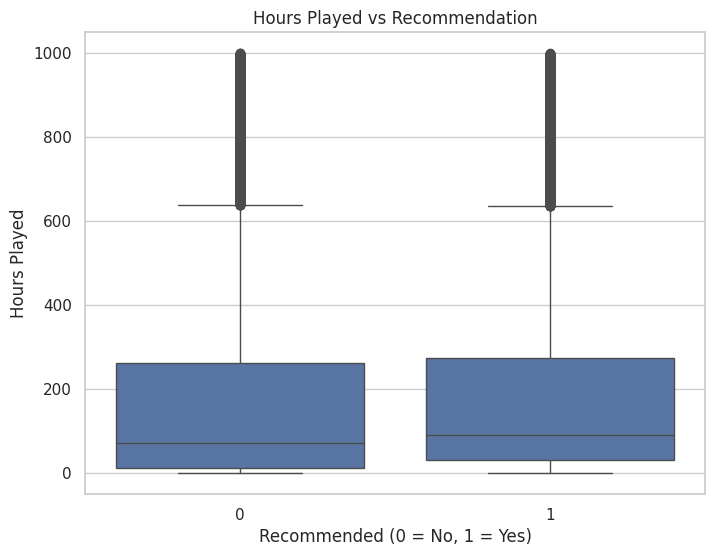

In [14]:
plt.figure(figsize=(8,6))
sns.boxplot(x="rec_binary", y="hours_played", data=data)
plt.title("Hours Played vs Recommendation")
plt.xlabel("Recommended (0 = No, 1 = Yes)")
plt.ylabel("Hours Played")
plt.show()


In [15]:
data[["hours_played", "rec_binary"]].corr()


,hours_played,rec_binary
hours_played,1.000000,0.027315
rec_binary,0.027315,1.000000


## Hypothesis Test 1: Do people who recommend play more?

- H0 (null): The average playtime is the same for recommending vs non-recommending reviews.  
- H1 (alt): Reviews that recommend the game have higher average playtime.

I will use an independent samples t-test.


In [16]:
rec = data[data["rec_binary"] == 1]["hours_played"]
not_rec = data[data["rec_binary"] == 0]["hours_played"]

t_stat, p_val = stats.ttest_ind(rec, not_rec, equal_var=False)

t_stat, p_val


(np.float64(7.000418956448029), np.float64(2.582547861786699e-12))

- If pvalue < 0.05, I reject H0 and conclude that recommended reviews are associated with significantly different (typically higher) playtime.
- If pvalue >= 0.05, I fail to reject H0 and cannot say there is a significant difference.


## Hypothesis Test 2: Is there a correlation between playtime and recommendation?

Here, rec_binary is 0/1 and hours_playe d is continuous.

- H1: There is no correlation between hours played and recommendation.
- H1: There is a non-zero correlation between hours played and recommendation.


In [18]:
corr, p_corr = stats.pearsonr(data["hours_played"], data["rec_binary"])
corr, p_corr


(np.float64(0.027314749244380696), np.float64(2.2009555344895983e-12))

- corr shows the strength and direction of the relationship (closer to 1 or -1 = stronger).
- If pvalue < 0.05, the correlation is statistically significant.


In [ ]:
- I loaded and cleaned a Steam game reviews dataset.
- I explored the distribution of playtime and recommendation labels.
- Boxplots and descriptive statistics suggest that recommended reviews tend to have different playtime patterns.
- A t-test was used to compare average playtime between recommended vs non-recommended reviews.
- A correlation test examined the association between hours played and recommendation.